In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import r2_score
'''
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10
'''
#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

Instructions for updating:
non-resource variables are not supported in the long term


/: ['tmp', 'boot', 'srv', 'dev', 'run', 'home', 'opt', 'sbin', 'lib', 'lib64', 'bin', 'etc', 'usr', 'libx32', 'var', 'lib32', 'mnt', 'proc', 'media', 'sys', 'root', 'content', 'kaggle', '.dockerenv', 'datalab', 'tools', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']
/content: ['.config', '233010.csv', 'sample_data']


In [ ]:
# import all stock prices
df = pd.read_csv("/content/233010.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.stock_id))))
print(list(set(df.stock_id))[:10])

columns_to_drop = ['stock_id', 'Trading_Volume', 'Trading_money',
                   'spread', 'Trading_turnover']
df.drop(columns=columns_to_drop, axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2444 entries, 2014-05-07 to 2024-05-07
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stock_id          2444 non-null   int64  
 1   Trading_Volume    2444 non-null   int64  
 2   Trading_money     2444 non-null   int64  
 3   open              2444 non-null   float64
 4   max               2444 non-null   float64
 5   min               2444 non-null   float64
 6   close             2444 non-null   float64
 7   spread            2444 non-null   float64
 8   Trading_turnover  2444 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 190.9+ KB

number of different stocks:  1
[2330]


In [ ]:
df.tail()

,open,max,min,close
date,,,,
2024-04-30,797.0,802.0,790.0,790.0
2024-05-02,789.0,789.0,772.0,772.0
2024-05-03,788.0,788.0,773.0,780.0
2024-05-06,791.0,793.0,786.0,786.0
2024-05-07,797.0,800.0,792.0,800.0


In [ ]:
df.describe()

,open,max,min,close
count,2444.000000,2444.000000,2444.000000,2444.000000
mean,336.403232,338.701923,333.748159,336.286825
std,183.555885,184.729384,182.076774,183.387072
min,118.000000,119.000000,112.500000,115.000000
25%,181.500000,183.500000,181.375000,182.375000
50%,252.500000,254.000000,250.750000,252.750000
75%,521.000000,524.000000,518.000000,520.250000
max,823.000000,826.000000,817.000000,820.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2444 entries, 2014-05-07 to 2024-05-07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2444 non-null   float64
 1   max     2444 non-null   float64
 2   min     2444 non-null   float64
 3   close   2444 non-null   float64
dtypes: float64(4)
memory usage: 95.5+ KB


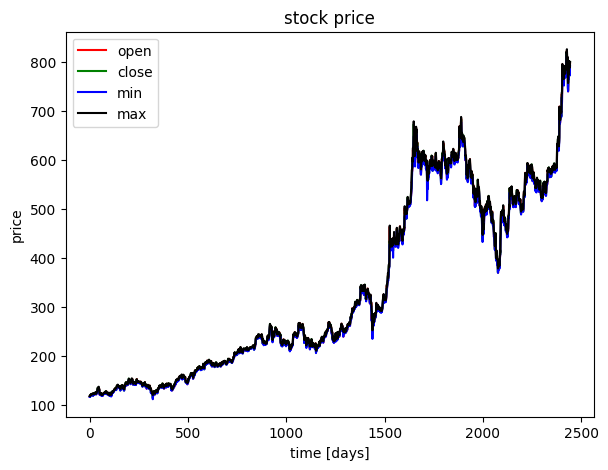

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df['open'].values, color='red', label='open')
plt.plot(df['close'].values, color='green', label='close')
plt.plot(df['min'].values, color='blue', label='min')
plt.plot(df['max'].values, color='black', label='max')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

In [ ]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df['open'].values.reshape(-1, 1))
    df['max'] = min_max_scaler.fit_transform(df['max'].values.reshape(-1, 1))
    df['min'] = min_max_scaler.fit_transform(df['min'].values.reshape(-1, 1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1, 1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len, valid_set_size_percentage=20, test_set_size_percentage=10):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage / 100 * data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1, :]

    x_test = data[train_set_size + valid_set_size:, :-1, :]
    y_test = data[train_set_size + valid_set_size:, -1, :]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

cols = list(df.columns.values)
print('df.columns.values = ', cols)

# normalize stock
df_norm = df.copy()
df_norm = normalize_data(df_norm)

seq_len = 20
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df.columns.values =  ['open', 'max', 'min', 'close']
x_train.shape =  (1697, 19, 4)
y_train.shape =  (1697, 4)
x_valid.shape =  (485, 19, 4)
y_valid.shape =  (485, 4)
x_test.shape =  (242, 19, 4)
y_test.shape =  (242, 4)


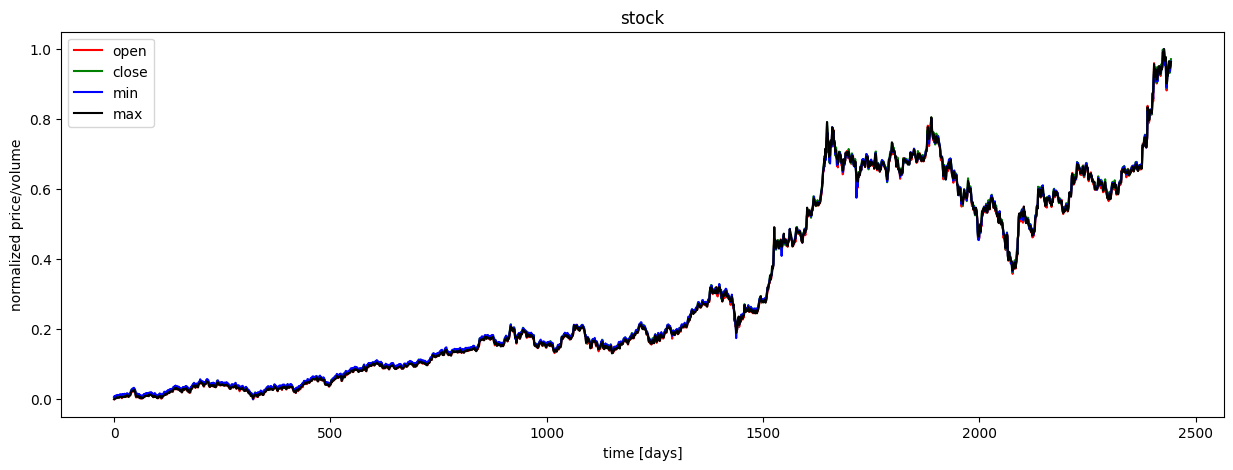

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df_norm['open'].values, color='red', label='open')
plt.plot(df_norm['close'].values, color='green', label='close')
plt.plot(df_norm['min'].values, color='blue', label='min')
plt.plot(df_norm['max'].values, color='black', label='max')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

Modified x_train.shape: (1697, 19, 4)
Modified x_valid.shape: (485, 19, 4)
Modified x_test.shape: (242, 19, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0 epochs: MSE train/valid = 0.044801/0.047906
Correct sign prediction train/valid: 0.55/0.46
5 epochs: MSE train/valid = 0.003054/0.016130
Correct sign prediction train/valid: 0.55/0.46
10 epochs: MSE train/valid = 0.000636/0.002072
Correct sign prediction train/valid: 0.45/0.54
15 epochs: MSE train/valid = 0.000524/0.001943
Correct sign prediction train/valid: 0.55/0.47
20 epochs: MSE train/valid = 0.000586/0.003496
Correct sign prediction train/valid: 0.52/0.53
25 epochs: MSE train/valid = 0.000365/0.001674
Correct sign prediction train/valid: 0.45/0.54
30 epochs: MSE train/valid = 0.001005/0.008017
Correct sign prediction train/valid: 0.58/0.54
35 epochs: MSE train/valid = 0.000432/0.001166
Correct sign prediction train/valid: 0.49/0.54
40 epochs: MSE train/valid = 0.000395/0.003283
Correct sign prediction train/valid: 0.58/0.51
45 epochs: MSE train/valid = 0.000408/0.000904
Correct sign prediction train/valid: 0.58/0.54
50 epochs: MSE train/valid = 0.000475/0.003230
Correct sign pr

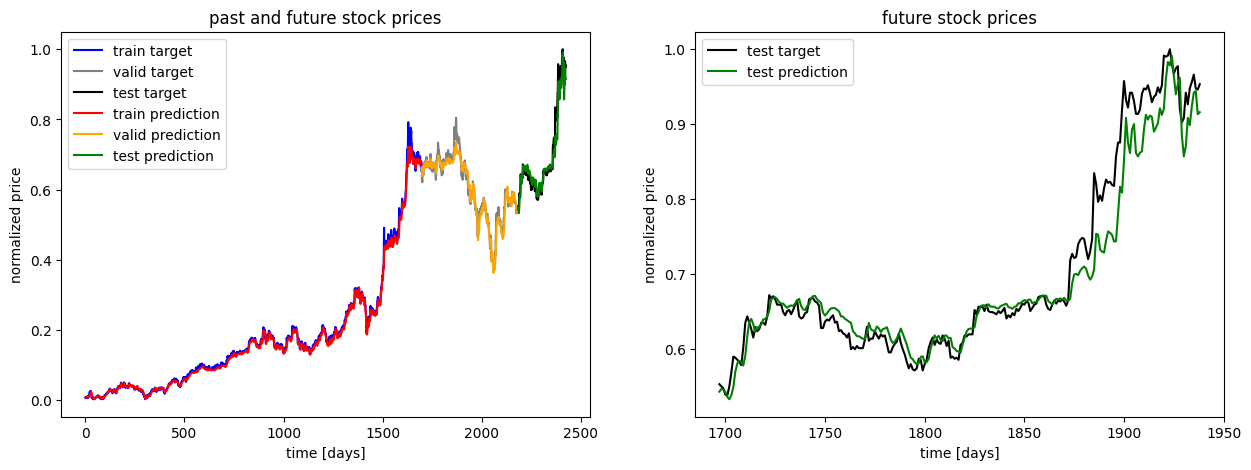

In [ ]:


print(f"Modified x_train.shape: {x_train.shape}")
print(f"Modified x_valid.shape: {x_valid.shape}")
print(f"Modified x_test.shape: {x_test.shape}")


index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size

    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# Parameters
n_steps = x_train.shape[1]
n_inputs = x_train.shape[2]
n_outputs = y_train.shape[1]
n_neurons = 200
n_layers = 3
learning_rate = 0.001
batch_size = 50
n_epochs = 250
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

# Build the model
model = tf.keras.Sequential()
for _ in range(n_layers):
    model.add(tf.keras.layers.LSTM(units=n_neurons, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.Dropout(rate=0.1)) # Lowered dropout rate
model.add(tf.keras.layers.LSTM(units=n_neurons, activation='relu'))
model.add(tf.keras.layers.Dense(units=n_outputs, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Train the model
for epoch in range(n_epochs):
    for iteration in range(train_set_size // batch_size):
        x_batch, y_batch = get_next_batch(batch_size)
        model.train_on_batch(x_batch, y_batch)

    if epoch % 5 == 0:
        mse_train = model.evaluate(x_train, y_train, verbose=0)
        mse_valid = model.evaluate(x_valid, y_valid, verbose=0)

        y_train_pred = model.predict(x_train)
        y_valid_pred = model.predict(x_valid)

        corr_price_development_train = np.sum(np.equal(np.sign(y_train[:, 1] - y_train[:, 0])
                        , np.sign(y_train_pred[:, 1] - y_train_pred[:, 0])).astype(int)) / y_train.shape[0]
        corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:, 1] - y_valid[:, 0])
                        , np.sign(y_valid_pred[:, 1] - y_valid_pred[:, 0])).astype(int)) / y_valid.shape[0]
        print(f'{epoch} epochs: MSE train/valid = {mse_train:.6f}/{mse_valid:.6f}')
        print(f'Correct sign prediction train/valid: {corr_price_development_train:.2f}/{corr_price_development_valid:.2f}')

y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)
y_test_pred = model.predict(x_test)

# Evaluate final loss on test set
mse_test = model.evaluate(x_test, y_test, verbose=0)
print(f'MSE on test set: {mse_test:.6f}')

r2 = r2_score(y_test, y_test_pred)
print(f'R²: {r2}')

# Plot the results
ft = 1 # 0 = open, 1 = close, 2 = highest, 3 = lowest
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:, ft], color='gray', label='valid target')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft], color='red', label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]), y_valid_pred[:, ft], color='orange', label='valid prediction')
plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:, ft], color='green', label='test prediction')
plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:, ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:, ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:, 1] - y_train[:, 0]), np.sign(y_train_pred[:, 1] - y_train_pred[:, 0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:, 1] - y_valid[:, 0]), np.sign(y_valid_pred[:, 1] - y_valid_pred[:, 0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:, 1] - y_test[:, 0]), np.sign(y_test_pred[:, 1] - y_test_pred[:, 0])).astype(int)) / y_test.shape[0]

print(f'correct sign prediction for close - open price for train/valid/test: {corr_price_development_train:.2f}/{corr_price_development_valid:.2f}/{corr_price_development_test:.2f}')


In [ ]:
y_train.shape

(1697, 4)